In [1]:
import os
import sys
sys.path.append(os.getcwd()+"/../..")
from src import paths

import torch

import pandas as pd

from src.utils import plot_embeddings, plot_confusion_matrix, performance_metrics, ms_label2id, ms_id2label, load_ms_data

from sklearn.metrics import classification_report

import matplotlib.pyplot as plt

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.colors as mcolors
import numpy as np

viridis_cmap = plt.get_cmap('viridis_r')
cmap = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)

# Extract a subset of colors from the "viridis" colormap
start_index = 120  # Start index of colors to include
end_index = 200 # End index of colors to include
subset_colors = viridis_cmap(np.linspace(start_index / 255, end_index / 255, end_index - start_index + 1))

# Create a custom colormap using the subset of colors
custom_cmap = mcolors.ListedColormap(subset_colors)
custom_cmap = sns.color_palette("light:#5A9", as_cmap=True)

def pretty_confusion_matrix(y_true, y_pred, labels):
    # Create the confusion matrix
    cm = confusion_matrix(y_true=y_true, y_pred=y_pred)

    # Plotting the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.set_theme(font_scale=1.2)  # Adjust font size for labels
    sns.heatmap(cm, annot=True, fmt='d', cmap=custom_cmap, cbar=False,
                yticklabels=labels, xticklabels=labels, alpha=0.9, linewidths=0.5, linecolor='lightgrey')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.yticks(rotation=0)
    plt.grid(False)
    plt.tight_layout()
    plt.show()

def show_results(file_name: str, plot_hidden_states = True) -> None:
    results = torch.load(paths.RESULTS_PATH / "ms-diag" / f"{file_name}")

    # Plot confusion matrix
    display_label_mapping = {0: "PPMS", 1: "RRMS", 2: "SPMS", 3: "Other"}
    pretty_confusion_matrix(y_true=results["labels"], y_pred=results["preds"], labels=display_label_mapping.values())

    # Plot embeddings
    if plot_hidden_states:
        # Exclude None values (for pipeline approach this is to be expected)
        results["last_hidden_state"] = [batch for batch in results["last_hidden_state"] if batch is not None]
        plot_labels = [results["labels"][i] for i in range(len(results["last_hidden_state"])) if results["last_hidden_state"][i] is not None]
        # plot_labels = [display_label_mapping[label] for label in plot_labels]
        
        # Last hidden states is a list of tensors of shape (seq_len, hidden_size)
        last_hidden_state = [batch[0, :] for batch in results["last_hidden_state"]]  # Use CLS token
        embeddings = torch.stack(last_hidden_state, dim=0).to(torch.float16)
        plot_embeddings(embeddings=embeddings, labels=plot_labels, title=file_name, method="umap")
        plt.show()

    # Print classification report
    labels = [display_label_mapping[label] for label in results["labels"]]
    preds = [display_label_mapping[pred] for pred in results["preds"]]
    print(classification_report(y_true=labels, y_pred=preds), "\n\n")

    # Show all wrongly classified samples
    for i in range(len(labels)):
        if labels[i] != preds[i]:
            print(f"Observation: {i}")
            print(f"Label: {labels[i]} - Prediction: {preds[i]}")
            try:
                print(results["text"][i])
            except:
                print(results["original_text"][i])
            # Print the probabilities for each class by converting the logits to probabilities, then rounding them
            print("Probabilities:", dict(zip(ms_label2id.keys(), [round(prob, 3) for prob in torch.softmax(torch.tensor(results["logits"][i]), dim=0).numpy()])), "\n\n")

# MedBERT 512

## Strategy: Classify on single lines, 4 Labels (including no MS) and oversampling for training

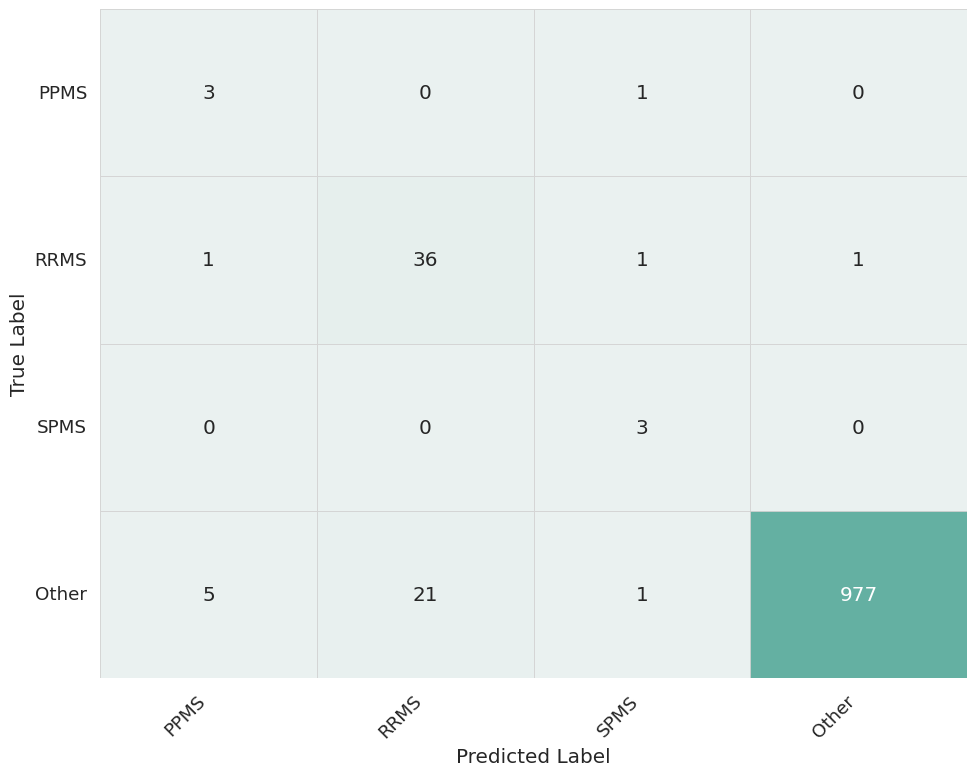

(1050, 2)


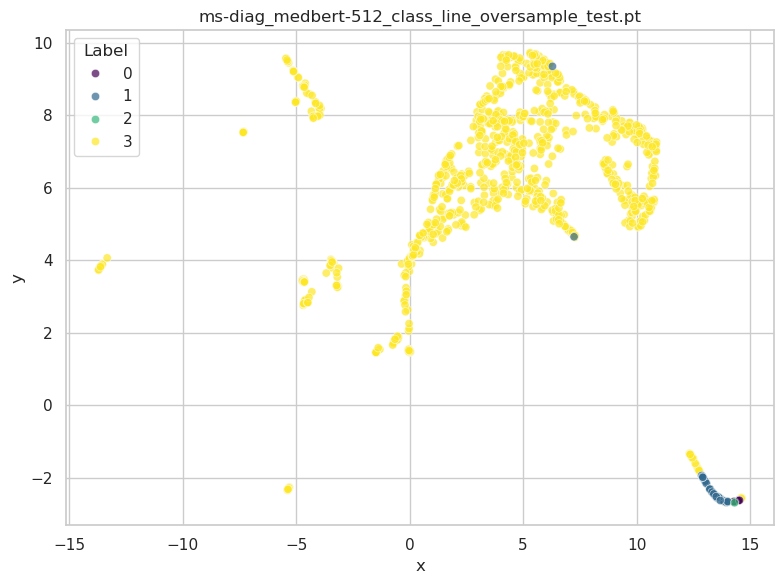

              precision    recall  f1-score   support

       Other       1.00      0.97      0.99      1004
        PPMS       0.33      0.75      0.46         4
        RRMS       0.63      0.92      0.75        39
        SPMS       0.50      1.00      0.67         3

    accuracy                           0.97      1050
   macro avg       0.62      0.91      0.72      1050
weighted avg       0.98      0.97      0.97      1050
 


Observation: 102
Label: Other - Prediction: PPMS
INDENT 2011-2016 langsam progrediente, rechtsbetonte spastisch-ataktische Gangstörung, distal betonte Pallhypästhesie und eingeschränktes Lageempfinden der unteren Extremität
Probabilities: {'primary_progressive_multiple_sclerosis': 0.942, 'relapsing_remitting_multiple_sclerosis': 0.0, 'secondary_progressive_multiple_sclerosis': 0.039, 'no_ms': 0.019} 


Observation: 124
Label: Other - Prediction: RRMS
INDENT Rituximab 375 mg/kg KöF: 1. Gabe am 28.06.2016 (600 mg), 2. Gabe am 12.01.2017 (608 mg), 3. Gabe am 

In [17]:
show_results("ms-diag_medbert-512_class_line_oversample_test.pt")

In [4]:
result = torch.load(paths.RESULTS_PATH / "ms-diag" / "ms-diag_medbert-512_class_line_oversample_test.pt")
# Creat DF from rid, pred, label, text
def majority_vote(result):
    # Create a DataFrame from the results
    df = pd.DataFrame({"rid": result["rid"], "preds": result["preds"], 
                   "labels": result["labels"], "text": result["text"], 
                   "logits": result["logits"], "last_hidden_state": result["last_hidden_state"],
                   "index_within_rid": result["index_within_rid"]})
    
    # All rids that have at least one prediction other than 3 (no MS)
    df_list = []

    for i, rid_data in df.groupby("rid"):
        # Get most frequent prediction from classes [0, 1, 2]
        # Take first of the lines predicted as this class
        _df = {}

        value_counts = rid_data["preds"].value_counts()

        if len(value_counts) == 1 or value_counts.index[0] != 3:
            majority_class = value_counts.index[0]
            _df["preds"] = majority_class
            _df["logits"] = rid_data[rid_data["preds"] == majority_class]["logits"].values[0]
            _df["last_hidden_state"] = rid_data[rid_data["preds"] == majority_class]["last_hidden_state"].values[0]

        elif len(value_counts) > 1 and value_counts.index[0] == 3:
            majority_class = value_counts.index[1]
            _df["preds"] = majority_class
            _df["logits"] = rid_data[rid_data["preds"] == majority_class]["logits"].values[0]
            _df["last_hidden_state"] = rid_data[rid_data["preds"] == majority_class]["last_hidden_state"].values[0]

        # There should only be one kind label other than 3 (no MS) or just 3
        if rid_data["labels"].value_counts().index[0] == 3 and len(rid_data["labels"].value_counts()) > 1:
            _df["labels"] = rid_data["labels"].value_counts().index[1]
        else:
            _df["labels"] = rid_data["labels"].value_counts().index[0]
        
        _df["rid"] = i
        _df["text"] = "\n".join(rid_data["text"].tolist())

        df_list.append(_df)
    
    return pd.DataFrame(df_list)

df_agg = majority_vote(result)
torch.save(df_agg.to_dict("list"), paths.RESULTS_PATH / "ms-diag" / "ms-diag_medbert-512_class_line_oversample_test_agg.pt")


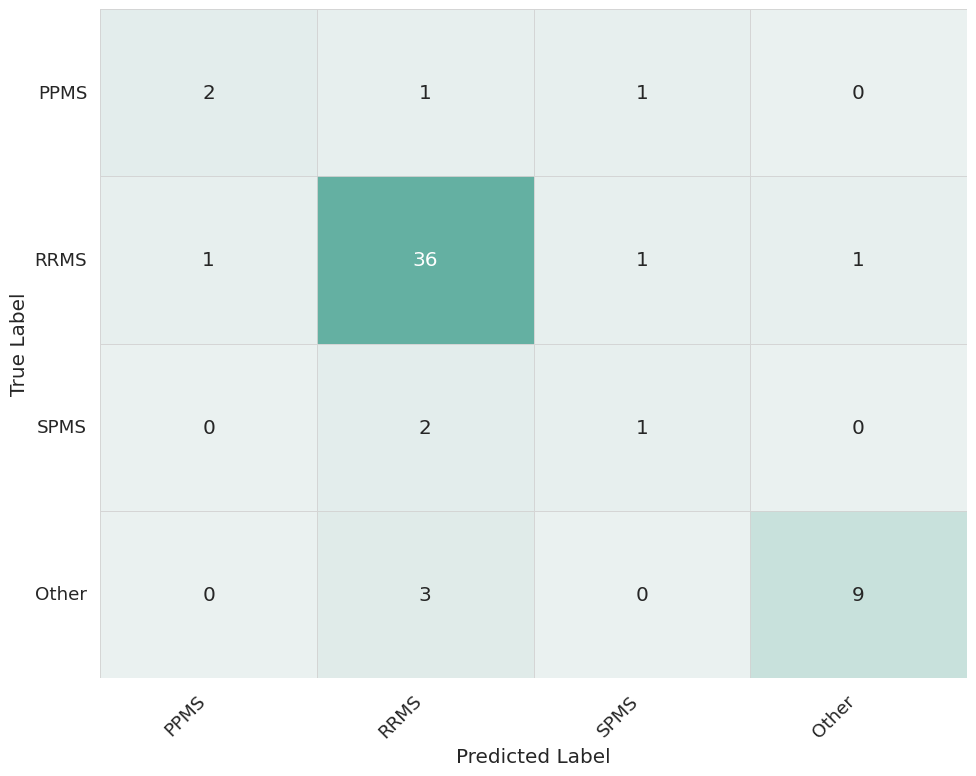

(58, 2)


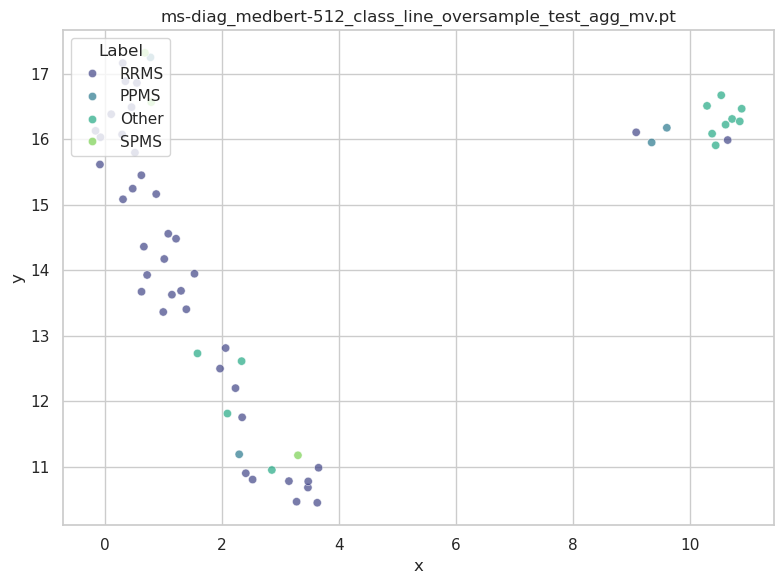

              precision    recall  f1-score   support

       Other       0.90      0.75      0.82        12
        PPMS       0.67      0.50      0.57         4
        RRMS       0.86      0.92      0.89        39
        SPMS       0.33      0.33      0.33         3

    accuracy                           0.83        58
   macro avg       0.69      0.63      0.65        58
weighted avg       0.83      0.83      0.82        58
 


Label: RRMS - Prediction: Other
INDENT aktuell Vd. a. zweiten Schub (Erstereignis 1997): 
INDENT seit 4-5 Wochen Schwäche re Bein und Arm; klinisch: leichtgradige Tetraparese rechtsbetont, Hypästhesie an beiden Fussohlen, zerebelläre Ataxie, Blickrichtungsnystagmus re>li,  Finger-Nase-Versuch dysmetrisch bds (li> re) Knie-Hacke-Versuch dysmetrisch bds. Links Dys-und Bradydiadochokinese, EDSS 3.0.
INDENT aktenanamnestisch: 
INDENT 1997 (Dr. Riederer): bei rez. Schwindelattacken mit Bewusstlosigkeit und motorischen Störungen am li Bein (im Verlauf komplett r

In [5]:
show_results("ms-diag_medbert-512_class_line_oversample_test_agg_mv.pt", plot_hidden_states=True)

The bad precision stems from the fact the we have an imbalanced dataset. Even though only 4 RRMS get classified wrong, it makes a huge difference for the precision of PPMS and SPMS as there are only so few examples.

## Strategy: Classify on single lines, 3 Labels (original approach with only dm samples) and oversampling for training

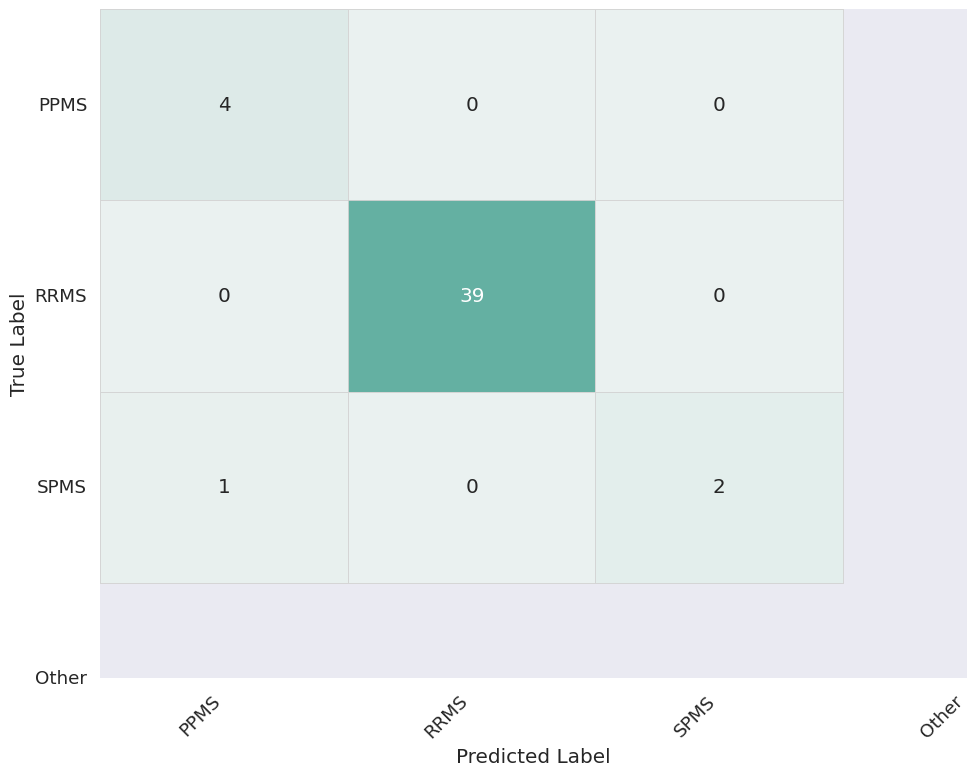

(46, 2)


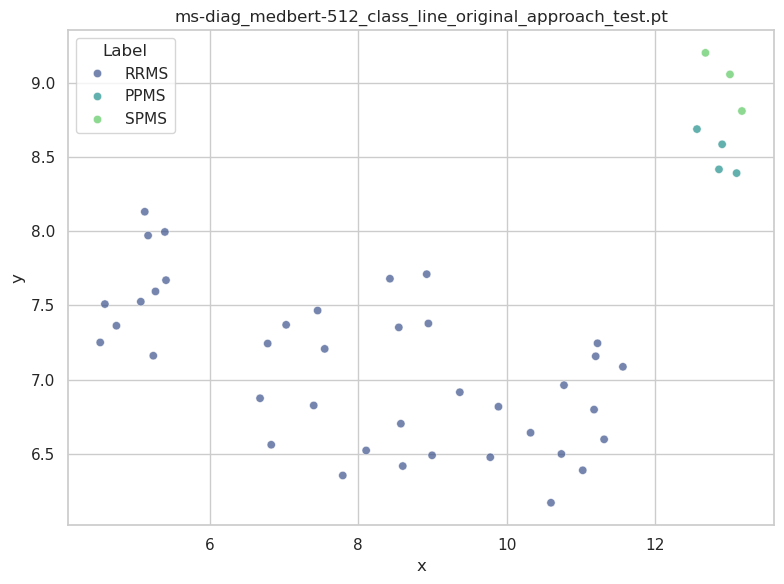

              precision    recall  f1-score   support

        PPMS       0.80      1.00      0.89         4
        RRMS       1.00      1.00      1.00        39
        SPMS       1.00      0.67      0.80         3

    accuracy                           0.98        46
   macro avg       0.93      0.89      0.90        46
weighted avg       0.98      0.98      0.98        46
 


Label: SPMS - Prediction: PPMS
Sekundär progrediente Multiple Sklerose (EM 1998, ED 1999), EDSS 7.0
Probabilities: {'primary_progressive_multiple_sclerosis': 0.998, 'relapsing_remitting_multiple_sclerosis': 0.0, 'secondary_progressive_multiple_sclerosis': 0.002} 




In [6]:
show_results("ms-diag_medbert-512_class_line_original_approach_test.pt")

## Strategy: Classify on whole report, 4 labels (including no ms) training on oversampled

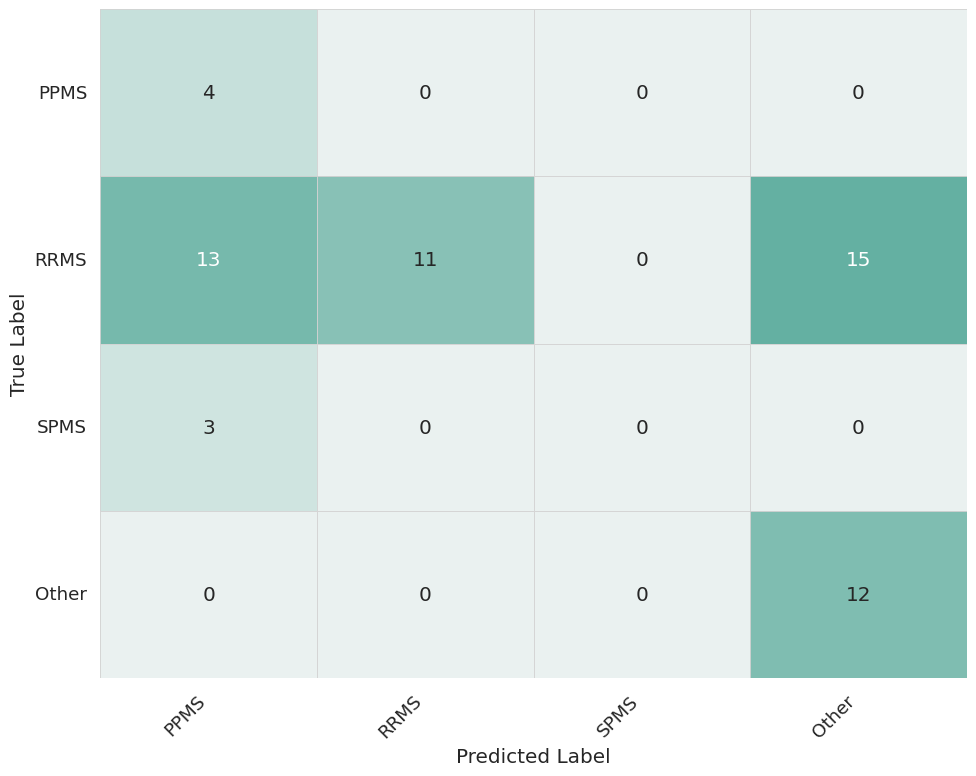

(58, 2)


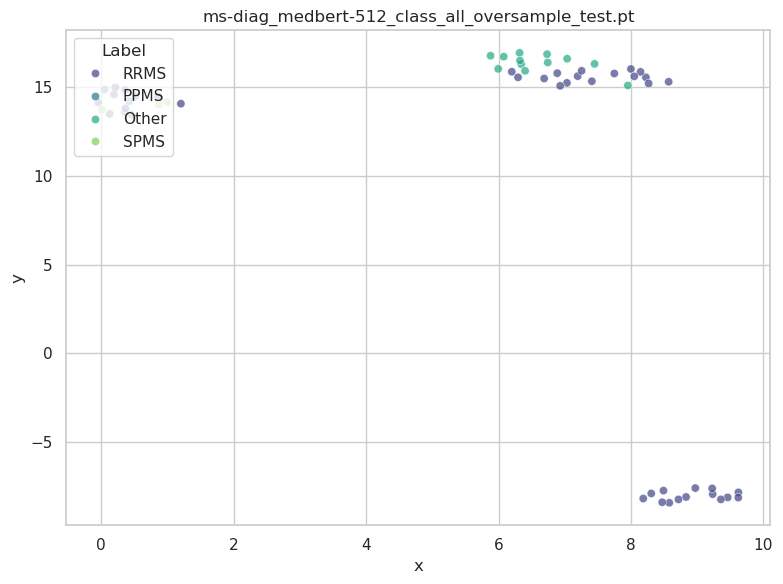

              precision    recall  f1-score   support

       Other       0.44      1.00      0.62        12
        PPMS       0.20      1.00      0.33         4
        RRMS       1.00      0.28      0.44        39
        SPMS       0.00      0.00      0.00         3

    accuracy                           0.47        58
   macro avg       0.41      0.57      0.35        58
weighted avg       0.78      0.47      0.45        58
 


Label: RRMS - Prediction: Other
Multiple Sklerose, spinale Form, schubförmig verlaufend, EM 05/1999, ED 05/1999
INDENT EDSS 06/2019: 1.5
INDENT MRI Kopf 11/2012: Im Vergleich zu Befund 2006 eine sichere neue Läsion am Temoralhorn rechts
INDENT MRI Kopf 03/2013: Stabil im Vergleich zu 2012
INDENT MRI Kopf 11/2018: Besser demarkierte demyelinisierende Läsionen, keine neuen/aktiven Läsionen cerebral oder im Bereich der Orbita, Hyperintensitäten am Myelon zervical Höhe HWK 2,3 - keine Vorbefunde spinal seit 1999
INDENT MRI spinal 02/2018: Multiple demyelinisie

/home/ubuntu/anaconda3/envs/inf-extr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/inf-extr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/inf-extr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

In [7]:
show_results("ms-diag_medbert-512_class_all_oversample_test.pt")

## Strategy: Classify on whole report, 3 Labels (original approach with only reports containing at least one dm line), oversampling for training

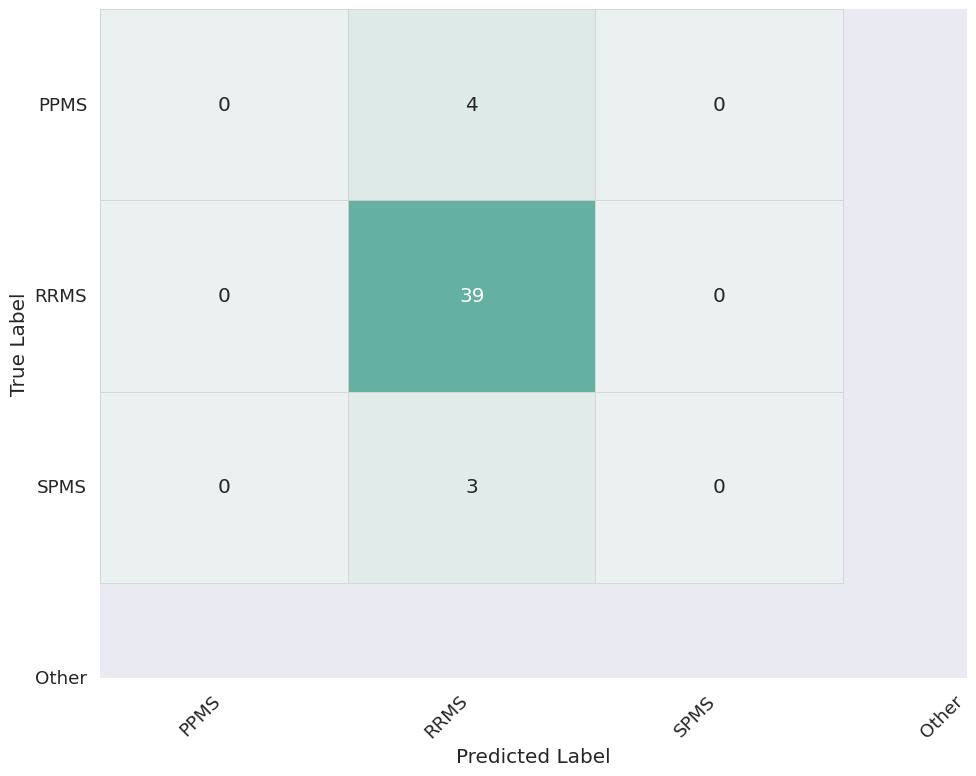

(46, 2)


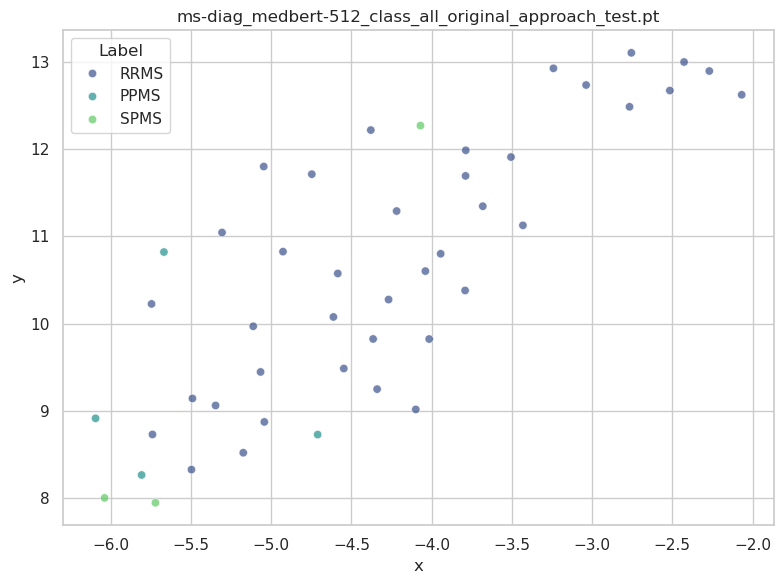

              precision    recall  f1-score   support

        PPMS       0.00      0.00      0.00         4
        RRMS       0.85      1.00      0.92        39
        SPMS       0.00      0.00      0.00         3

    accuracy                           0.85        46
   macro avg       0.28      0.33      0.31        46
weighted avg       0.72      0.85      0.78        46
 


Label: PPMS - Prediction: RRMS
Primär chronisch progrediente Multiple Sklerose, EM 2008, ED 2012, EDSS 4.0
aktuell: klinisch: stabil, radiologisch: stabil, Progression: ja (nach Lublin et al. 2013)
INDENT Besserung der Kraft im linken Bein. Probleme beim Laufen, leichte Urge-Symptomatik und gelegentliche Einschlafprobleme. Klinisch spastisch-ataktisches Gangbild mit linksbetonter Spastik in den UE, beidseits gesteigerter PSR, Fallneigung im Rombergstehversuch nach hinten. Leichte Pallhypästhesie der UE (6/8).
INDENT Verlauf: 
INDENT 1996 Sturz mit dem Rad
INDENT 2008 Lähmung des linken Beines nach körperl. Be

/home/ubuntu/anaconda3/envs/inf-extr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/inf-extr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/inf-extr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

In [8]:
show_results("ms-diag_medbert-512_class_all_original_approach_test.pt")

## Pipeline Approach:

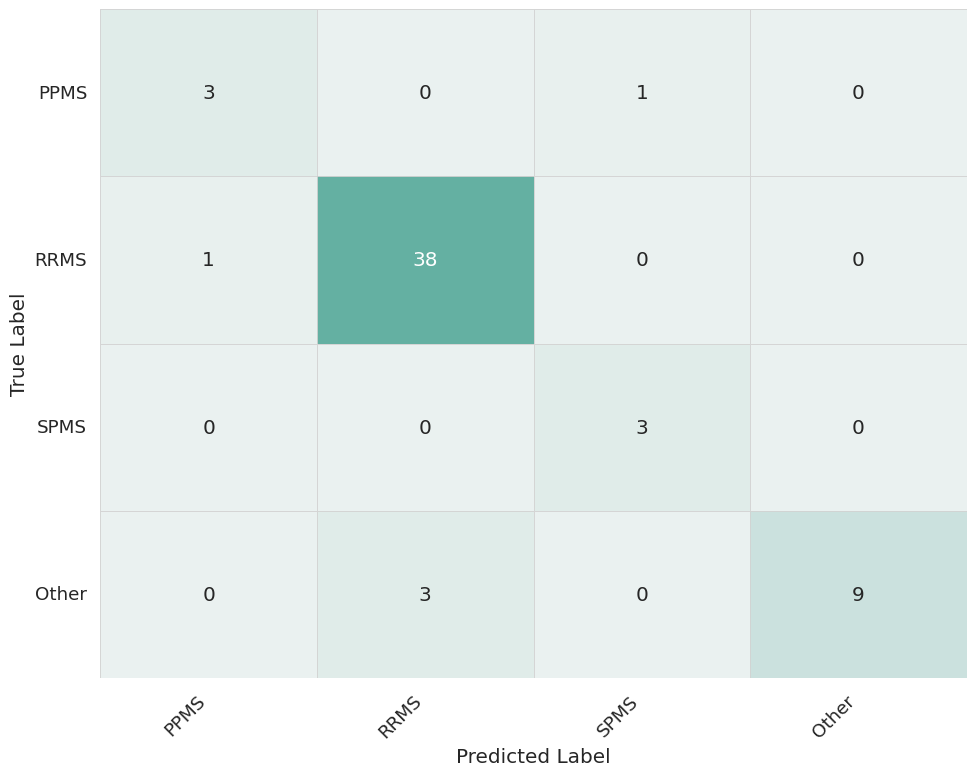

(49, 2)


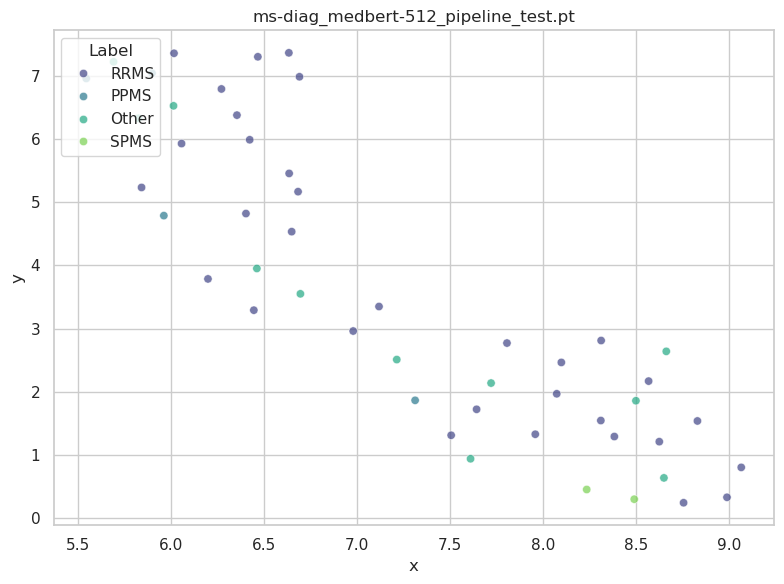

              precision    recall  f1-score   support

       Other       1.00      0.75      0.86        12
        PPMS       0.75      0.75      0.75         4
        RRMS       0.93      0.97      0.95        39
        SPMS       0.75      1.00      0.86         3

    accuracy                           0.91        58
   macro avg       0.86      0.87      0.85        58
weighted avg       0.92      0.91      0.91        58
 


Observation: 19
Label: Other - Prediction: RRMS
V.a. entzündliche ZNS-Erkrankung, EM 23.11.2015
INDENT DD CIS, ADEM
INDENT Anamnese: Kribbeln der linken Körperhälfte seit ca. 23.11.2015 langsam zunehmend; Mutter mit MS
INDENT Klinik: sensomotorisches beinbetontes Hemisyndrom links, Koordinationsstörung Hand links, Kraftgrad Bein links M4, im Verlauf zunehmend mit Parese im Arm links distal bis M4 und im Bein links M3, im weiteren Verlauf deutliche Regredienz, bei Austritt residuell diskrete Kraftminderung und Feinmotorikstörung in der linken Hand sowie lei

In [11]:
show_results("ms-diag_medbert-512_pipeline_test.pt")

In [14]:
# Label of obs 25 is wrong, should be Other
results_corrected = torch.load(paths.RESULTS_PATH / "ms-diag" / "ms-diag_medbert-512_pipeline_test.pt")
results_corrected["labels"][25] = 3
torch.save(results_corrected, paths.RESULTS_PATH / "ms-diag" / "ms-diag_medbert-512_pipeline_test_corrected.pt")

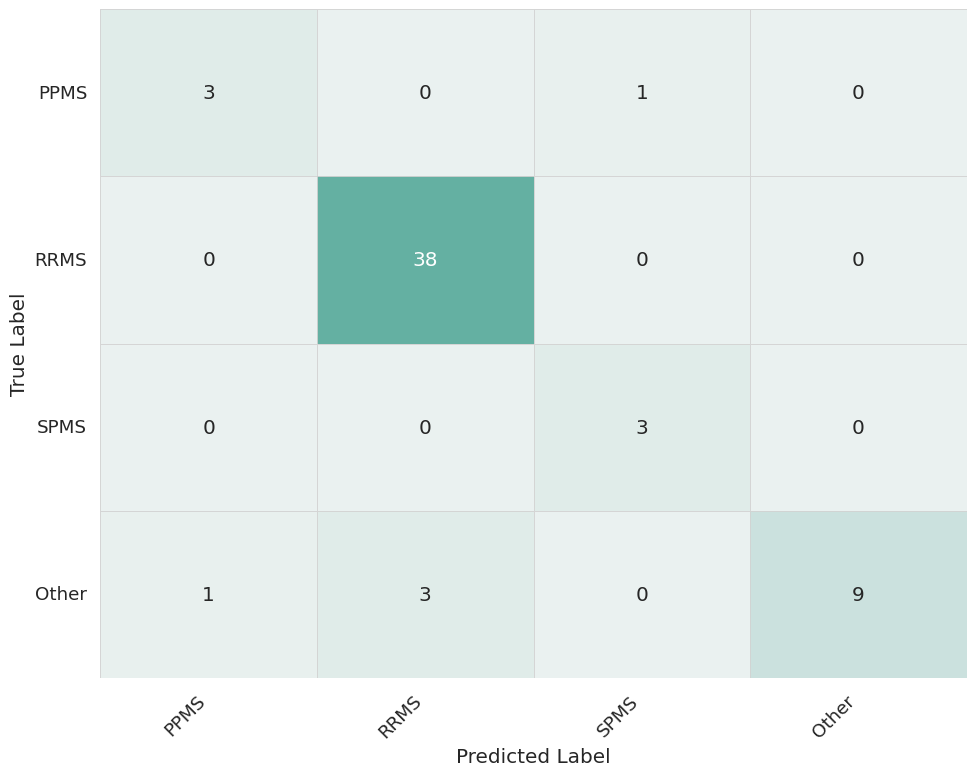

(49, 2)


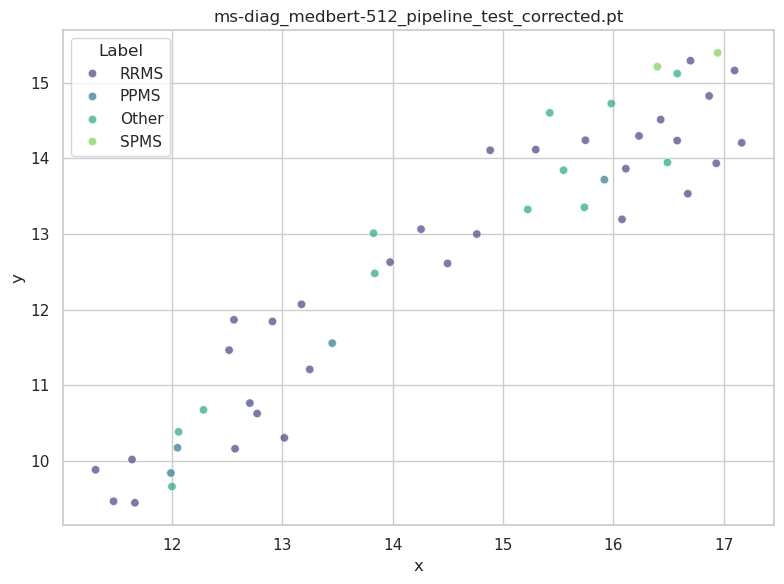

              precision    recall  f1-score   support

       Other       1.00      0.69      0.82        13
        PPMS       0.75      0.75      0.75         4
        RRMS       0.93      1.00      0.96        38
        SPMS       0.75      1.00      0.86         3

    accuracy                           0.91        58
   macro avg       0.86      0.86      0.85        58
weighted avg       0.92      0.91      0.91        58
 


Observation: 19
Label: Other - Prediction: RRMS
V.a. entzündliche ZNS-Erkrankung, EM 23.11.2015
INDENT DD CIS, ADEM
INDENT Anamnese: Kribbeln der linken Körperhälfte seit ca. 23.11.2015 langsam zunehmend; Mutter mit MS
INDENT Klinik: sensomotorisches beinbetontes Hemisyndrom links, Koordinationsstörung Hand links, Kraftgrad Bein links M4, im Verlauf zunehmend mit Parese im Arm links distal bis M4 und im Bein links M3, im weiteren Verlauf deutliche Regredienz, bei Austritt residuell diskrete Kraftminderung und Feinmotorikstörung in der linken Hand sowie lei

In [15]:
show_results("ms-diag_medbert-512_pipeline_test_corrected.pt")